In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


In [6]:
try:
    reddit_tech = pd.read_csv('../reddit_tech_subs/data/reddit_ai_tech_20251102_1836.csv')
    reddit_nontech = pd.read_csv('../reddit_non_tech_subs/data/reddit_ai_nontech_20251102_1847.csv')
    youtube_tech = pd.read_csv('../youtube_data/youtube_comments_20251103_0104.csv')
except FileNotFoundError:
    raise FileNotFoundError("Preprocessed CSV not found. Check your path.")


In [7]:
# Add platform/category labels
reddit_tech['category'] = 'Reddit Tech'
reddit_nontech['category'] = 'Reddit Non-Tech'
youtube_tech['category'] = 'YouTube Tech'

In [8]:
print(f"\nDataset sizes:")
print(f"  Reddit Tech: {len(reddit_tech)} rows")
print(f"  Reddit Non-Tech: {len(reddit_nontech)} rows")
print(f"  YouTube Tech: {len(youtube_tech)} rows")
print(f"  Total: {len(reddit_tech) + len(reddit_nontech) + len(youtube_tech)} rows")


Dataset sizes:
  Reddit Tech: 2244 rows
  Reddit Non-Tech: 1246 rows
  YouTube Tech: 688 rows
  Total: 4178 rows


In [11]:
reddit_tech.head()

,Unnamed: 0,subreddit,type,id,parent_id,created_utc,score,num_comments,url,content,neg,neu,pos,compound,sent_label,category
0,0,MachineLearning,post,1olehrk,NaN,1.761969e+09,53,14.0,https://www.reddit.com/r/MachineLearning/comme...,[D] Realized I like the coding and ML side of ...,0.013,0.815,0.172,0.9895,pos,Reddit Tech
1,1,MachineLearning,post,1oggr5l,NaN,1.761473e+09,45,37.0,https://www.reddit.com/r/MachineLearning/comme...,[D] Building low cost GPU compute in Africa ch...,0.057,0.874,0.070,0.5927,pos,Reddit Tech
2,2,MachineLearning,post,1ojqgq4,NaN,1.761799e+09,38,3.0,https://www.reddit.com/r/MachineLearning/comme...,[P] I made a tool to search papers from select...,0.000,0.909,0.091,0.5994,pos,Reddit Tech
3,3,MachineLearning,post,1okdq0s,NaN,1.761863e+09,26,14.0,https://www.reddit.com/r/MachineLearning/comme...,[R] We found LRMs look great…until the problem...,0.055,0.896,0.049,-0.6740,neg,Reddit Tech
4,4,MachineLearning,post,1ojwyye,NaN,1.761823e+09,17,7.0,https://www.reddit.com/r/MachineLearning/comme...,[P] `triton_bwd`: Enabling Backpropagation for...,0.028,0.828,0.144,0.9397,pos,Reddit Tech


In [12]:
reddit_nontech.head()

,Unnamed: 0,subreddit,type,id,parent_id,created_utc,score,num_comments,url,content,neg,neu,pos,compound,sent_label,category
0,0,writing,post,1oi5jlx,NaN,1.761647e+09,1,1.0,https://www.reddit.com/r/writing/comments/1oi5...,"Book Club Scam (?) Hi everyone, I'm quite new ...",0.076,0.813,0.111,0.7301,pos,Reddit Non-Tech
1,1,writing,post,1om3fol,NaN,1.762043e+09,0,13.0,https://www.reddit.com/r/writing/comments/1om3...,Concerns With Storytelling with My Art I am so...,0.055,0.836,0.109,0.9599,pos,Reddit Non-Tech
2,2,writing,post,1ogrbxz,NaN,1.761502e+09,0,26.0,https://www.reddit.com/r/writing/comments/1ogr...,Let's discuss the paradox of Utopian fiction I...,0.074,0.825,0.101,0.8761,pos,Reddit Non-Tech
3,3,Screenwriting,post,1okdm7s,NaN,1.761863e+09,13,25.0,https://www.reddit.com/r/Screenwriting/comment...,DEFCON ONE - FEATURE - 104 pages) appreciate f...,0.117,0.719,0.165,0.2960,pos,Reddit Non-Tech
4,4,Screenwriting,post,1ohb9po,NaN,1.761563e+09,9,35.0,https://www.reddit.com/r/Screenwriting/comment...,"What makes a script ""Lynchian""? My husband is ...",0.062,0.835,0.103,0.8743,pos,Reddit Non-Tech


In [13]:
youtube_tech.head()

,Unnamed: 0,video_id,id,parent_id,author,created_utc,score,content,category
0,0,sTeoEFzVNSc,UgyHAdzyGGobT8qiWph4AaABAg,NaN,@programmingwithmosh,1.673633,1427,"Whether you like ChatGPT or not, remember: Cha...",YouTube Tech
1,1,sTeoEFzVNSc,UgyHAdzyGGobT8qiWph4AaABAg.9kppxbFGGEc9kpw5I_SsiM,UgyHAdzyGGobT8qiWph4AaABAg,@RUFMUT,1.673636,5,@programmingwithmosh Thank you for video. But ...,YouTube Tech
2,2,sTeoEFzVNSc,UgykJ_-KODLohk9I77h4AaABAg,NaN,@Innoodrr,1.754735,0,ChatGPT Tutorial for Developers - 38 Ways to 1...,YouTube Tech
3,3,sTeoEFzVNSc,UgyJ_YALNNX2nYdSCzh4AaABAg,NaN,@arindamghosh3787,1.743242,0,I developed a custom Bot application and deplo...,YouTube Tech
4,4,sTeoEFzVNSc,UgwwKEPbrC66zBjpfwR4AaABAg,NaN,@shawnz1,1.741755,0,and #39 use a powerful Chrome extension like c...,YouTube Tech


In [10]:
# Normalize YouTube columns to match Reddit structure
youtube_tech = youtube_tech.rename(columns={
    'likes': 'score',
    'created_at': 'created_utc'
})

# Convert YouTube datetime to unix timestamp
youtube_tech['created_utc'] = pd.to_datetime(youtube_tech['created_utc']).astype(int) / 10**9

youtube_tech.head()


,Unnamed: 0,video_id,id,parent_id,author,created_utc,score,content,category
0,0,sTeoEFzVNSc,UgyHAdzyGGobT8qiWph4AaABAg,NaN,@programmingwithmosh,1.673633,1427,"Whether you like ChatGPT or not, remember: Cha...",YouTube Tech
1,1,sTeoEFzVNSc,UgyHAdzyGGobT8qiWph4AaABAg.9kppxbFGGEc9kpw5I_SsiM,UgyHAdzyGGobT8qiWph4AaABAg,@RUFMUT,1.673636,5,@programmingwithmosh Thank you for video. But ...,YouTube Tech
2,2,sTeoEFzVNSc,UgykJ_-KODLohk9I77h4AaABAg,NaN,@Innoodrr,1.754735,0,ChatGPT Tutorial for Developers - 38 Ways to 1...,YouTube Tech
3,3,sTeoEFzVNSc,UgyJ_YALNNX2nYdSCzh4AaABAg,NaN,@arindamghosh3787,1.743242,0,I developed a custom Bot application and deplo...,YouTube Tech
4,4,sTeoEFzVNSc,UgwwKEPbrC66zBjpfwR4AaABAg,NaN,@shawnz1,1.741755,0,and #39 use a powerful Chrome extension like c...,YouTube Tech


In [21]:
# Run sentiment analysis on YouTube data (Reddit already has it)
print("\nRunning sentiment analysis on YouTube data...")
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text):
        return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}
    return analyzer.polarity_scores(str(text))

youtube_sentiment = youtube_tech['content'].apply(get_sentiment)
youtube_tech['neg'] = youtube_sentiment.apply(lambda x: x['neg'])
youtube_tech['neu'] = youtube_sentiment.apply(lambda x: x['neu'])
youtube_tech['pos'] = youtube_sentiment.apply(lambda x: x['pos'])
youtube_tech['compound'] = youtube_sentiment.apply(lambda x: x['compound'])

# Add sentiment labels
def label_sentiment(compound):
    if compound >= 0.05:
        return 'pos'
    elif compound <= -0.05:
        return 'neg'
    else:
        return 'neu'

youtube_tech['sent_label'] = youtube_tech['compound'].apply(label_sentiment)

youtube_tech.head()


Running sentiment analysis on YouTube data...


,Unnamed: 0,video_id,id,parent_id,author,created_utc,score,content,category,neg,neu,pos,compound,sent_label
0,0,sTeoEFzVNSc,UgyHAdzyGGobT8qiWph4AaABAg,NaN,@programmingwithmosh,1.673633,1427,"Whether you like ChatGPT or not, remember: Cha...",YouTube Tech,0.000,0.831,0.169,0.6705,pos
1,1,sTeoEFzVNSc,UgyHAdzyGGobT8qiWph4AaABAg.9kppxbFGGEc9kpw5I_SsiM,UgyHAdzyGGobT8qiWph4AaABAg,@RUFMUT,1.673636,5,@programmingwithmosh Thank you for video. But ...,YouTube Tech,0.000,0.811,0.189,0.6553,pos
2,2,sTeoEFzVNSc,UgykJ_-KODLohk9I77h4AaABAg,NaN,@Innoodrr,1.754735,0,ChatGPT Tutorial for Developers - 38 Ways to 1...,YouTube Tech,0.000,1.000,0.000,0.0000,neu
3,3,sTeoEFzVNSc,UgyJ_YALNNX2nYdSCzh4AaABAg,NaN,@arindamghosh3787,1.743242,0,I developed a custom Bot application and deplo...,YouTube Tech,0.052,0.815,0.134,0.8153,pos
4,4,sTeoEFzVNSc,UgwwKEPbrC66zBjpfwR4AaABAg,NaN,@shawnz1,1.741755,0,and #39 use a powerful Chrome extension like c...,YouTube Tech,0.000,0.570,0.430,0.8834,pos


In [22]:
# Select common columns
common_cols = ['category', 'content', 'created_utc', 'score', 
               'neg', 'neu', 'pos', 'compound', 'sent_label']

# Add any missing columns with default values
for df in [reddit_tech, reddit_nontech, youtube_tech]:
    for col in common_cols:
        if col not in df.columns:
            df[col] = None

# Combine datasets
df = pd.concat([
    reddit_tech[common_cols],
    reddit_nontech[common_cols],
    youtube_tech[common_cols]
], ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4178 entries, 0 to 4177
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   category     4178 non-null   object 
 1   content      4178 non-null   object 
 2   created_utc  4178 non-null   float64
 3   score        4178 non-null   int64  
 4   neg          4178 non-null   float64
 5   neu          4178 non-null   float64
 6   pos          4178 non-null   float64
 7   compound     4178 non-null   float64
 8   sent_label   4178 non-null   object 
dtypes: float64(5), int64(1), object(3)
memory usage: 293.9+ KB


In [23]:
# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['created_utc'], unit='s')
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()

df['content_length'] = df['content'].str.len()
df['word_count'] = df['content'].str.split().str.len()

# Create platform grouping (Reddit vs YouTube)
df['platform'] = df['category'].apply(lambda x: 'Reddit' if 'Reddit' in x else 'YouTube')

df.head()


,category,content,created_utc,score,neg,neu,pos,compound,sent_label,datetime,date,hour,day_of_week,content_length,word_count,platform
0,Reddit Tech,[D] Realized I like the coding and ML side of ...,1.761969e+09,53,0.013,0.815,0.172,0.9895,pos,2025-11-01 03:56:20,2025-11-01,3,Saturday,1271,215,Reddit
1,Reddit Tech,[D] Building low cost GPU compute in Africa ch...,1.761473e+09,45,0.057,0.874,0.070,0.5927,pos,2025-10-26 09:57:53,2025-10-26,9,Sunday,835,138,Reddit
2,Reddit Tech,[P] I made a tool to search papers from select...,1.761799e+09,38,0.000,0.909,0.091,0.5994,pos,2025-10-30 04:30:28,2025-10-30,4,Thursday,290,56,Reddit
3,Reddit Tech,[R] We found LRMs look great…until the problem...,1.761863e+09,26,0.055,0.896,0.049,-0.6740,neg,2025-10-30 22:29:26,2025-10-30,22,Thursday,1580,239,Reddit
4,Reddit Tech,[P] `triton_bwd`: Enabling Backpropagation for...,1.761823e+09,17,0.028,0.828,0.144,0.9397,pos,2025-10-30 11:21:04,2025-10-30,11,Thursday,730,118,Reddit


In [26]:
category_stats = df.groupby('category').agg({
    'compound': ['mean', 'median', 'std', 'min', 'max'],
    'pos': 'mean',
    'neg': 'mean',
    'neu': 'mean',
    'score': ['mean', 'median'],
    'content': 'count'
}).round(3)

category_stats

compound                                pos    neg    neu  \
                    mean median    std    min    max   mean   mean   mean   
category                                                                    
Reddit Non-Tech    0.315  0.527  0.632 -0.996  1.000  0.110  0.065  0.825   
Reddit Tech        0.241  0.352  0.570 -0.992  1.000  0.113  0.067  0.820   
YouTube Tech       0.304  0.361  0.484 -0.968  0.998  0.139  0.047  0.814   

                  score        content  
                   mean median   count  
category                                
Reddit Non-Tech  34.507    2.0    1246  
Reddit Tech      61.298    2.0    2244  
YouTube Tech      7.135    0.0     688

In [27]:
# Sentiment label distribution
print("Sentiment Distribution (%):")
sentiment_dist = df.groupby(['category', 'sent_label']).size().unstack(fill_value=0)
sentiment_pct = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0) * 100
print(sentiment_pct.round(1))

# Statistical tests
print("\n" + "-"*80)
print("Statistical Significance Tests (Sentiment Differences):")

categories = df['category'].unique()
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        cat1, cat2 = categories[i], categories[j]
        data1 = df[df['category'] == cat1]['compound']
        data2 = df[df['category'] == cat2]['compound']
        t_stat, p_value = stats.ttest_ind(data1, data2)
        
        print(f"\n{cat1} vs {cat2}:")
        print(f"  Mean difference: {data1.mean() - data2.mean():.3f}")
        print(f"  T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")
        print(f"  Significant: {'YES' if p_value < 0.05 else 'NO'}")

Sentiment Distribution (%):
sent_label        neg   neu   pos
category                         
Reddit Non-Tech  27.8   7.5  64.7
Reddit Tech      27.4  13.9  58.8
YouTube Tech     16.4  22.4  61.2

--------------------------------------------------------------------------------
Statistical Significance Tests (Sentiment Differences):

Reddit Tech vs Reddit Non-Tech:
  Mean difference: -0.074
  T-statistic: -3.550, P-value: 0.0004
  Significant: YES

Reddit Tech vs YouTube Tech:
  Mean difference: -0.063
  T-statistic: -2.635, P-value: 0.0085
  Significant: YES

Reddit Non-Tech vs YouTube Tech:
  Mean difference: 0.011
  T-statistic: 0.400, P-value: 0.6891
  Significant: NO


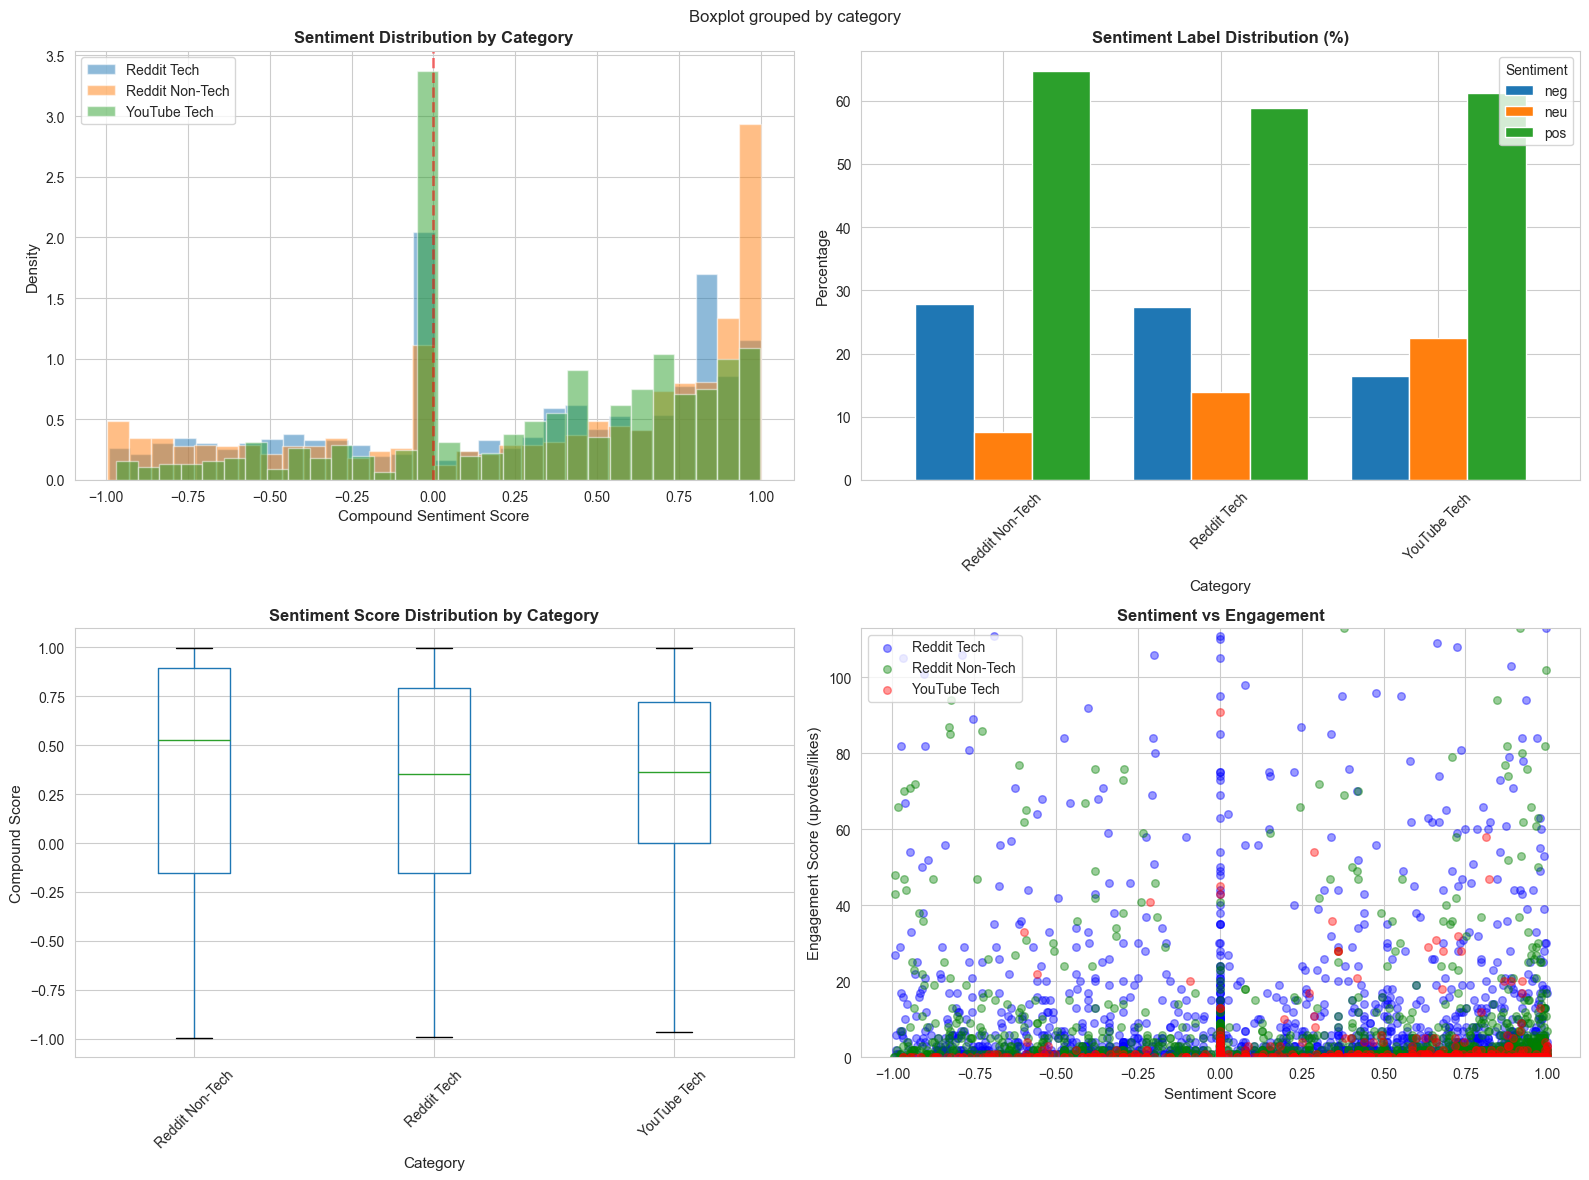

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Compound sentiment distribution
for category in df['category'].unique():
    data = df[df['category'] == category]['compound']
    axes[0, 0].hist(data, alpha=0.5, bins=30, label=category, density=True)
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
axes[0, 0].set_xlabel('Compound Sentiment Score', fontsize=11)
axes[0, 0].set_ylabel('Density', fontsize=11)
axes[0, 0].set_title('Sentiment Distribution by Category', fontsize=12, fontweight='bold')
axes[0, 0].legend()

# 2. Sentiment category breakdown
sentiment_pct.plot(kind='bar', ax=axes[0, 1], width=0.8)
axes[0, 1].set_title('Sentiment Label Distribution (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Percentage', fontsize=11)
axes[0, 1].set_xlabel('Category', fontsize=11)
axes[0, 1].legend(title='Sentiment', loc='upper right')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Box plot comparison
df.boxplot(column='compound', by='category', ax=axes[1, 0])
axes[1, 0].set_title('Sentiment Score Distribution by Category', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Compound Score', fontsize=11)
axes[1, 0].set_xlabel('Category', fontsize=11)
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# 4. Engagement vs Sentiment
colors = {'Reddit Tech': 'blue', 'Reddit Non-Tech': 'green', 'YouTube Tech': 'red'}
for category in df['category'].unique():
    data = df[df['category'] == category]
    axes[1, 1].scatter(data['compound'], data['score'], 
                      alpha=0.4, label=category, s=30, color=colors[category])
axes[1, 1].set_xlabel('Sentiment Score', fontsize=11)
axes[1, 1].set_ylabel('Engagement Score (upvotes/likes)', fontsize=11)
axes[1, 1].set_title('Sentiment vs Engagement', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].set_ylim(0, df['score'].quantile(0.95))

plt.tight_layout()
plt.savefig('01_cross_category_overview.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
df.head()

,category,content,created_utc,score,neg,neu,pos,compound,sent_label,datetime,date,hour,day_of_week,content_length,word_count,platform
0,Reddit Tech,[D] Realized I like the coding and ML side of ...,1.761969e+09,53,0.013,0.815,0.172,0.9895,pos,2025-11-01 03:56:20,2025-11-01,3,Saturday,1271,215,Reddit
1,Reddit Tech,[D] Building low cost GPU compute in Africa ch...,1.761473e+09,45,0.057,0.874,0.070,0.5927,pos,2025-10-26 09:57:53,2025-10-26,9,Sunday,835,138,Reddit
2,Reddit Tech,[P] I made a tool to search papers from select...,1.761799e+09,38,0.000,0.909,0.091,0.5994,pos,2025-10-30 04:30:28,2025-10-30,4,Thursday,290,56,Reddit
3,Reddit Tech,[R] We found LRMs look great…until the problem...,1.761863e+09,26,0.055,0.896,0.049,-0.6740,neg,2025-10-30 22:29:26,2025-10-30,22,Thursday,1580,239,Reddit
4,Reddit Tech,[P] `triton_bwd`: Enabling Backpropagation for...,1.761823e+09,17,0.028,0.828,0.144,0.9397,pos,2025-10-30 11:21:04,2025-10-30,11,Thursday,730,118,Reddit


In [29]:
reddit_data = df[df['platform'] == 'Reddit'].copy()

tech_vs_nontech = reddit_data.groupby('category').agg({
    'compound': ['mean', 'std'],
    'word_count': 'mean',
    'score': 'mean'
}).round(3)

print("\nTech vs Non-Tech Comparison:")
print(tech_vs_nontech)

# Polarization analysis
print("\n" + "-"*80)
print("Polarization Analysis:")
for category in ['Reddit Tech', 'Reddit Non-Tech']:
    data = reddit_data[reddit_data['category'] == category]['compound']
    extreme_pos = (data > 0.5).sum() / len(data) * 100
    extreme_neg = (data < -0.5).sum() / len(data) * 100
    
    print(f"\n{category}:")
    print(f"  Extreme positive (>0.5): {extreme_pos:.1f}%")
    print(f"  Extreme negative (<-0.5): {extreme_neg:.1f}%")
    print(f"  Total polarization: {extreme_pos + extreme_neg:.1f}%")


Tech vs Non-Tech Comparison:
                compound        word_count   score
                    mean    std       mean    mean
category                                          
Reddit Non-Tech    0.315  0.632    135.213  34.507
Reddit Tech        0.241  0.570     77.437  61.298

--------------------------------------------------------------------------------
Polarization Analysis:

Reddit Tech:
  Extreme positive (>0.5): 41.4%
  Extreme negative (<-0.5): 14.2%
  Total polarization: 55.7%

Reddit Non-Tech:
  Extreme positive (>0.5): 50.9%
  Extreme negative (<-0.5): 15.8%
  Total polarization: 66.7%


In [34]:
tech_data = df[df['category'].isin(['Reddit Tech', 'YouTube Tech'])].copy()

platform_comparison = tech_data.groupby('platform').agg({
    'compound': ['mean', 'std'],
    'word_count': 'mean',
    'score': 'mean',
    'content': 'count'
}).round(3)

print("\nPlatform Statistics (Tech content only):")
print(platform_comparison)


Platform Statistics (Tech content only):
         compound        word_count   score content
             mean    std       mean    mean   count
platform                                           
Reddit      0.241  0.570     77.437  61.298    2244
YouTube     0.304  0.484     53.916   7.135     688



Content metrics by category:
                content_length        word_count       
                          mean median       mean median
category                                               
Reddit Non-Tech         765.47  492.5     135.21   86.5
Reddit Tech             453.33  242.0      77.44   43.5
YouTube Tech            300.37  128.0      53.92   23.0

--------------------------------------------------------------------------------
Correlation: Word Count vs Sentiment
  Reddit Tech: 0.176
  Reddit Non-Tech: 0.186
  YouTube Tech: 0.271


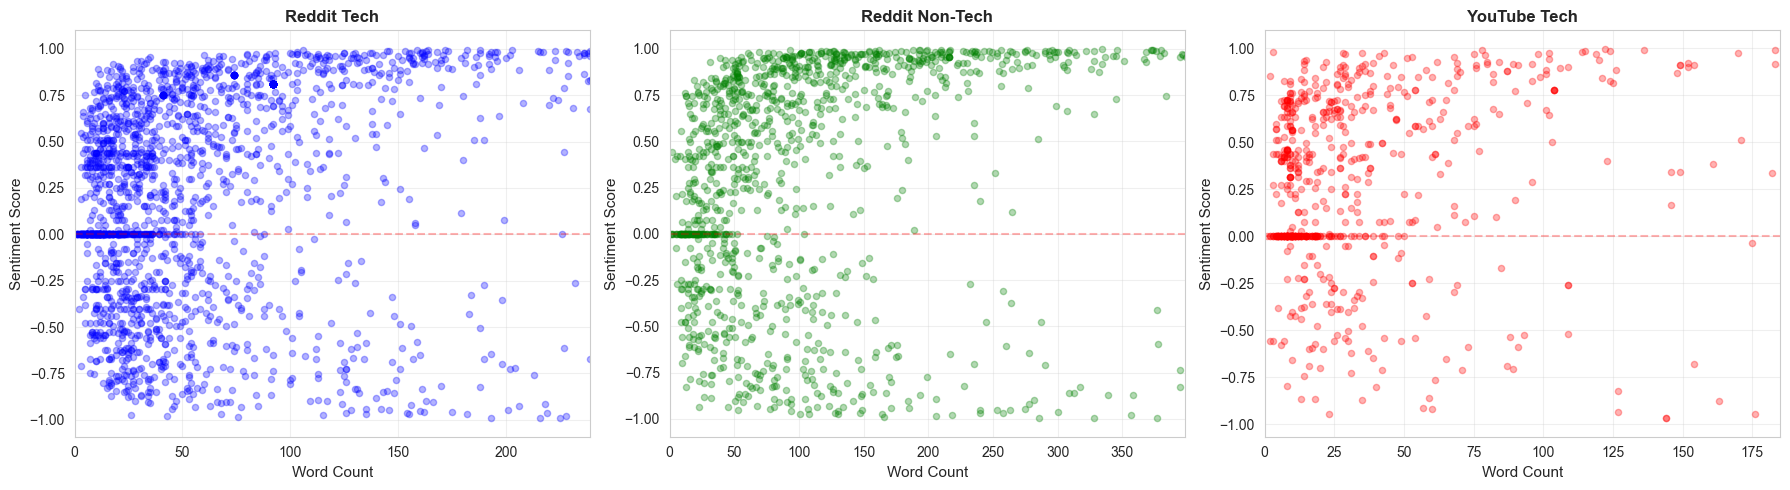

In [36]:
length_stats = df.groupby('category').agg({
    'content_length': ['mean', 'median'],
    'word_count': ['mean', 'median']
}).round(2)

print("\nContent metrics by category:")
print(length_stats)

# Correlation analysis
print("\n" + "-"*80)
print("Correlation: Word Count vs Sentiment")
for category in df['category'].unique():
    data = df[df['category'] == category]
    corr = data[['word_count', 'compound']].corr().iloc[0, 1]
    print(f"  {category}: {corr:.3f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, category in enumerate(df['category'].unique()):
    data = df[df['category'] == category]
    axes[idx].scatter(data['word_count'], data['compound'], 
                     alpha=0.3, s=20, color=colors[category])
    axes[idx].set_xlabel('Word Count', fontsize=11)
    axes[idx].set_ylabel('Sentiment Score', fontsize=11)
    axes[idx].set_title(category, fontsize=12, fontweight='bold')
    axes[idx].set_xlim(0, data['word_count'].quantile(0.95))
    axes[idx].axhline(y=0, color='red', linestyle='--', alpha=0.3)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_length_vs_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
df.head()

,category,content,created_utc,score,neg,neu,pos,compound,sent_label,datetime,date,hour,day_of_week,content_length,word_count,platform
0,Reddit Tech,[D] Realized I like the coding and ML side of ...,1.761969e+09,53,0.013,0.815,0.172,0.9895,pos,2025-11-01 03:56:20,2025-11-01,3,Saturday,1271,215,Reddit
1,Reddit Tech,[D] Building low cost GPU compute in Africa ch...,1.761473e+09,45,0.057,0.874,0.070,0.5927,pos,2025-10-26 09:57:53,2025-10-26,9,Sunday,835,138,Reddit
2,Reddit Tech,[P] I made a tool to search papers from select...,1.761799e+09,38,0.000,0.909,0.091,0.5994,pos,2025-10-30 04:30:28,2025-10-30,4,Thursday,290,56,Reddit
3,Reddit Tech,[R] We found LRMs look great…until the problem...,1.761863e+09,26,0.055,0.896,0.049,-0.6740,neg,2025-10-30 22:29:26,2025-10-30,22,Thursday,1580,239,Reddit
4,Reddit Tech,[P] `triton_bwd`: Enabling Backpropagation for...,1.761823e+09,17,0.028,0.828,0.144,0.9397,pos,2025-10-30 11:21:04,2025-10-30,11,Thursday,730,118,Reddit


In [54]:
def extract_top_keywords(texts, n=15):
    """Extract top keywords from text corpus"""
    if len(texts) == 0:
        return []
    
    vectorizer = CountVectorizer(max_features=1000, stop_words='english', 
                                  ngram_range=(1, 2), min_df=2)
    try:
        X = vectorizer.fit_transform(texts)
        word_freq = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
        return sorted(word_freq, key=lambda x: x[1], reverse=True)[:n]
    except:
        return []

for category in df['category'].unique():
    category_data = df[df['category'] == category]
    
    print(f"\n{category.upper()}")
    print("-" * 60)
    
    for sentiment in ['pos', 'neg']:
        sentiment_data = category_data[category_data['sent_label'] == sentiment]
        count = len(sentiment_data)
        
        if count > 0:
            keywords = extract_top_keywords(sentiment_data['content'], n=12)
            print(f"\n{sentiment.capitalize()} ({count} comments):")
            print(", ".join([f"{word}({int(freq)})" for word, freq in keywords[:12]]))


REDDIT TECH
------------------------------------------------------------

Pos (1319 comments):
ai(1025), chatgpt(806), like(660), post(519), just(513), image(499), openai(448), prompt(401), gpt(394), conversation(340), people(319), concerns(315)

Neg (614 comments):
ai(398), chatgpt(300), just(228), people(177), like(172), gpt(153), use(119), don(110), openai(95), think(81), using(80), know(78)

REDDIT NON-TECH
------------------------------------------------------------

Pos (806 comments):
ai(1246), like(542), just(498), ve(366), work(340), use(336), time(330), don(326), people(276), know(247), want(245), make(225)

Neg (346 comments):
ai(592), just(189), use(127), like(125), people(119), don(110), students(104), time(104), work(104), ve(81), know(77), job(73)

YOUTUBE TECH
------------------------------------------------------------

Pos (421 comments):
chatgpt(610), ai(274), like(192), code(148), use(134), just(114), using(113), don(79), make(74), time(74), dan(72), coding(67)

Ne


Engagement (score) by category and sentiment:
                             mean  median  count
category        sent_label                      
Reddit Non-Tech neg         41.30     3.0    346
                neu         11.99     2.0     94
                pos         34.22     2.0    806
Reddit Tech     neg         91.23     3.0    614
                neu         74.51     3.0    311
                pos         44.25     2.0   1319
YouTube Tech    neg          9.24     0.0    113
                neu          6.44     0.0    154
                pos          6.82     0.0    421


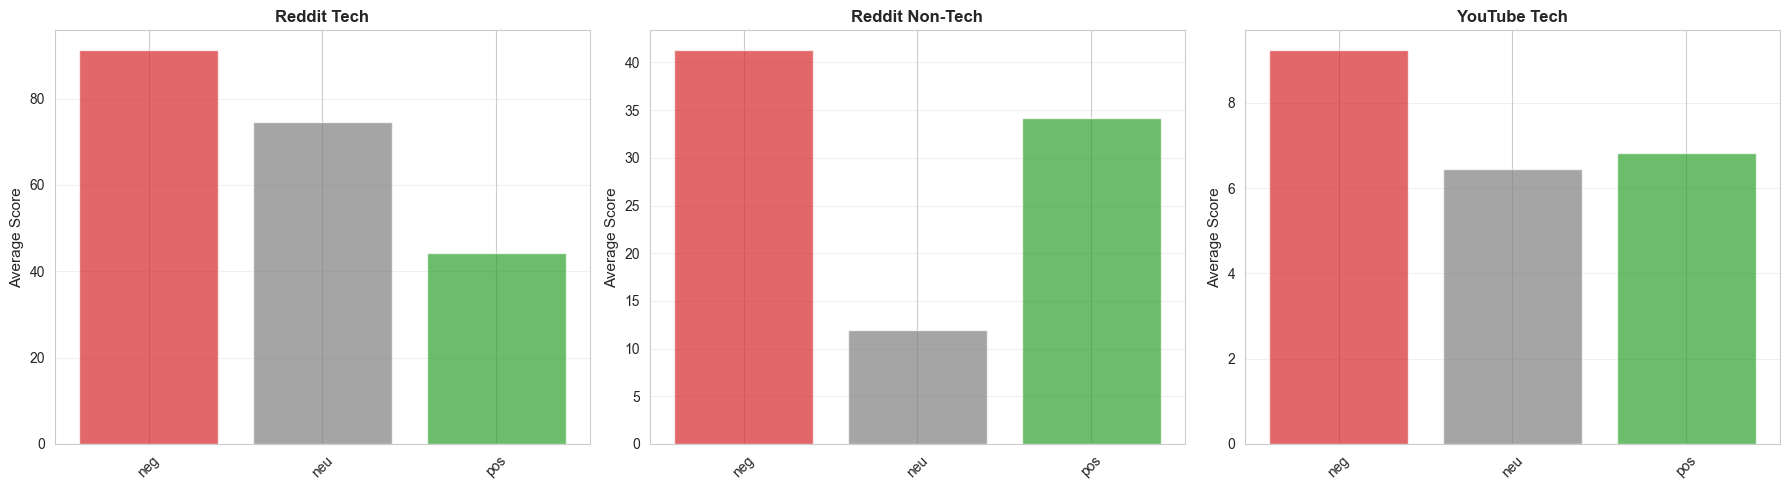

In [56]:
engagement_stats = df.groupby(['category', 'sent_label'])['score'].agg(
    ['mean', 'median', 'count']
).round(2)

print("\nEngagement (score) by category and sentiment:")
print(engagement_stats)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, category in enumerate(df['category'].unique()):
    data = df[df['category'] == category]
    engagement = data.groupby('sent_label')['score'].mean().reindex(
        ['neg', 'neu', 'pos']
    )
    
    bars = axes[idx].bar(range(len(engagement)), engagement.values, 
                         color=['#d62728', '#7f7f7f', '#2ca02c'], alpha=0.7)
    axes[idx].set_xticks(range(len(engagement)))
    axes[idx].set_xticklabels(engagement.index, rotation=45)
    axes[idx].set_ylabel('Average Score', fontsize=11)
    axes[idx].set_title(category, fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('05_engagement_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
# Calculate key metrics
reddit_tech_mean = df[df['category'] == 'Reddit Tech']['compound'].mean()
reddit_nontech_mean = df[df['category'] == 'Reddit Non-Tech']['compound'].mean()
youtube_mean = df[df['category'] == 'YouTube Tech']['compound'].mean()

print("\n1. OVERALL SENTIMENT:")
print(f"   Reddit Tech: {reddit_tech_mean:.3f}")
print(f"   Reddit Non-Tech: {reddit_nontech_mean:.3f}")
print(f"   YouTube Tech: {youtube_mean:.3f}")

most_positive = df.groupby('category')['compound'].mean().idxmax()
most_negative = df.groupby('category')['compound'].mean().idxmin()
print(f"\n   Most positive: {most_positive}")
print(f"   Most negative: {most_negative}")

print("\n2. POLARIZATION:")
for category in df['category'].unique():
    data = df[df['category'] == category]['compound']
    polarization = ((data > 0.5).sum() + (data < -0.5).sum()) / len(data) * 100
    print(f"   {category}: {polarization:.1f}%")

print("\n3. ENGAGEMENT PATTERNS:")
for category in df['category'].unique():
    data = df[df['category'] == category]
    pos_eng = data[data['sent_label'] == 'pos']['score'].mean()
    neg_eng = data[data['sent_label'] == 'neg']['score'].mean()
    print(f"   {category}:")
    print(f"     Positive sentiment avg score: {pos_eng:.1f}")
    print(f"     Negative sentiment avg score: {neg_eng:.1f}")
    print(f"     {'Positive' if pos_eng > neg_eng else 'Negative'} gets more engagement")

print("\n4. CONTENT LENGTH:")
for category in df['category'].unique():
    avg_words = df[df['category'] == category]['word_count'].mean()
    print(f"   {category}: {avg_words:.1f} words average")



1. OVERALL SENTIMENT:
   Reddit Tech: 0.241
   Reddit Non-Tech: 0.315
   YouTube Tech: 0.304

   Most positive: Reddit Non-Tech
   Most negative: Reddit Tech

2. POLARIZATION:
   Reddit Tech: 55.7%
   Reddit Non-Tech: 66.7%
   YouTube Tech: 48.0%

3. ENGAGEMENT PATTERNS:
   Reddit Tech:
     Positive sentiment avg score: 44.2
     Negative sentiment avg score: 91.2
     Negative gets more engagement
   Reddit Non-Tech:
     Positive sentiment avg score: 34.2
     Negative sentiment avg score: 41.3
     Negative gets more engagement
   YouTube Tech:
     Positive sentiment avg score: 6.8
     Negative sentiment avg score: 9.2
     Negative gets more engagement

4. CONTENT LENGTH:
   Reddit Tech: 77.4 words average
   Reddit Non-Tech: 135.2 words average
   YouTube Tech: 53.9 words average


In [62]:
df.to_csv("combined_dataset.csv", index=False)